In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['axes.grid'] = False
plt.style.context('Solarize_Light2')

roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9]
get_crit_T = dict(zip(jds, roots))
num_temps = 100

markers=['.', '^', 'X', 's', '*']
colors=['blue', 'orange', 'green', 'red', 'm']

In [6]:
def errs(errs):
    return np.array([sum(errs[i*512:(i+1)*512])/512 for i in range(num_temps)])

def stds_err(errs):
    return np.array([np.std(errs[i*512:(i+1)*512]) for i in range(num_temps)])

In [300]:
df_res = pd.DataFrame(columns=['$J_d$', 'L', '\mu', 'T_c', '\sigma', '\sigma_r', '\sigma_l'])

In [461]:
Jd = 0.0
T_c = get_crit_T[Jd]
T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)

opt_epochs = np.load('opt_epochs.npy', allow_pickle='TRUE').item()
epochs = opt_epochs[Jd]

errs_ = []
outs_ = []
Ls = [20, 30, 60, 80]
#epochs = [3] * len(Ls)

for i, L in enumerate(Ls):
    num_epochs = epochs[i]
    with open(f'data_errors/{Jd}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
        errs_.append(np.load(f)) 
    with open(f'data_outputs/{Jd}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
        outs_.append(np.squeeze(np.load(f)))

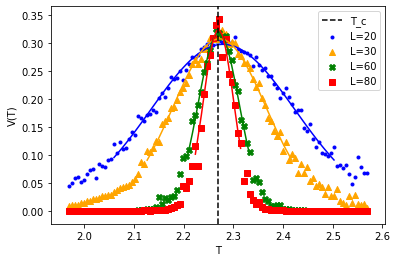

In [462]:
from scipy.optimize import curve_fit

def gaussian(x, amp, mu, sigma):
    return (amp/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x-mu)**2 / (2*sigma**2))


def gaussian_fit(x, y):
    popt, pcov = curve_fit(gaussian, xdata=x, ydata=y,
                              absolute_sigma=False, maxfev=1000000)
    return popt, pcov

def gaussian_fit_with_p(x, y, p):
    popt, pcov = curve_fit(gaussian, xdata=x, ydata=y,
                              absolute_sigma=False, p0=p, maxfev=1000000)
    return popt, pcov

#p_ = [[np.max(errs(errs_[j])), T[np.argmax(errs(errs_[j]))], np.std(errs(errs_[j])) / 2] for j in range(len(Ls))]
p_ = [[np.max(stds_err(outs_[j])), T[np.argmax(stds_err(outs_[j]))], np.std(stds_err(outs_[j])) / 2] for j in range(len(Ls))]


#data = [stds_err(outs_[j][:, 0]) for j in range(len(Ls))]

if Jd in [-0.9, -0.8]:
    threshold = [0.0, 0.0, 0.0, 0.0, 0.0]
elif Jd in [-0.7, -0.6]:
    threshold = [0.05, 0.05, 0.05, 0.05, 0.05]
else:
    threshold = [0.1, 0.1, 0.1, 0.1, 0.1]

# threshold = [0.1, 0.1, 0.05, 0.05, 0.01]
#threshold = [0.1, 0.1, 0.1, 0.1, 0.1]
# threshold = [0.05, 0.05, 0.05, 0.05, 0.05]
# threshold = [0.1, 0.1, 0.05, 0.05, 0.05]
# threshold = [0.0, 0.0, 0.0, 0.0, 0.0]

data = [stds_err(outs_[j])[stds_err(outs_[j]) > threshold[j]] for j in range(len(Ls))]
temp = [T[stds_err(outs_[j]) > threshold[j]] for j in range(len(Ls))]


#tmp = [gaussian_fit_with_p(y=errs(errs_[j]), x=T, p=p_[j]) for j in range(len(Ls))]
tmp = [gaussian_fit_with_p(y=data[j], x=temp[j], p=p_[j]) for j in range(len(Ls))]
#tmp = [gaussian_fit(y=data[j], x=temp[j]) for j in range(len(Ls))]

popt_ = np.array([tmp[j][0] for j in range(len(Ls))])
pcov_ = np.array([tmp[j][1] for j in range(len(Ls))])

plt.figure()

markers=['.', '^', 'X', 's', '*']
colors=['blue', 'orange', 'green', 'red', 'm']

for j in range(len(Ls)):
    plt.plot(temp[j], gaussian(temp[j], popt_[j][0], popt_[j][1], popt_[j][2]), c=colors[j])
    plt.scatter(T, stds_err(outs_[j]), marker=markers[j], c=colors[j], label=f'L={Ls[j]}')
    
    #plt.scatter(T, stds_err(outs_[j][:, 0]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    #plt.scatter(T, errs(errs_[j]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')

plt.axvline(x=T_c, color='black', linestyle='--', label='T_c')

#plt.axvline(x=popt_[2][1] - 3*popt_[2][2], color='blue', linestyle='-')
#plt.axvline(x=popt_[2][1] + 3*popt_[2][2], color='blue', linestyle='-')

#plt.title(f'M = {M}')
plt.xlabel('T')
plt.ylabel('V(T)')
plt.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()

In [463]:
perr_ = np.array([np.sqrt(np.diag(pcov_[j, :])) for j in range(len(Ls))])
popt_, perr_

(array([[0.10850851, 2.27901722, 0.14530301],
        [0.07188762, 2.27222397, 0.09318028],
        [0.03275517, 2.27059205, 0.04096176],
        [0.0248086 , 2.27018827, 0.03048081]]),
 array([[0.00083418, 0.0011229 , 0.00145156],
        [0.00058493, 0.00077382, 0.00098059],
        [0.00043444, 0.00055268, 0.00070411],
        [0.00071077, 0.00087529, 0.00112578]]))

In [464]:
df = pd.DataFrame(columns=['$J_d$', 'L', '\mu', 'T_c', '\sigma', '\sigma_r', '\sigma_l'])
df['$J_d$'] = [Jd]*len(Ls)
df['L'] = [20,30,60,80]

mus = []
for i in range(popt_[:, 1].shape[0]):
    mus.append(str(round(popt_[i, 1], 4)) + '(' + str(round(perr_[i, 1], 4)) + ')')
    
df['\mu'] = mus 
df['T_c'] = np.round([T_c]*len(Ls), 3)

sigmas = []
for i in range(popt_[:, 2].shape[0]):
    sigmas.append(str(round(popt_[i, 2], 4)) + '(' + str(round(perr_[i, 2], 4)) + ')')
    
df['\sigma'] = sigmas

In [465]:
df

,$J_d$,L,\mu,T_c,\sigma,\sigma_r,\sigma_l
0,0.0,20,2.279(0.0011),2.269,0.1453(0.0015),NaN,NaN
1,0.0,30,2.2722(0.0008),2.269,0.0932(0.001),NaN,NaN
2,0.0,60,2.2706(0.0006),2.269,0.041(0.0007),NaN,NaN
3,0.0,80,2.2702(0.0009),2.269,0.0305(0.0011),NaN,NaN


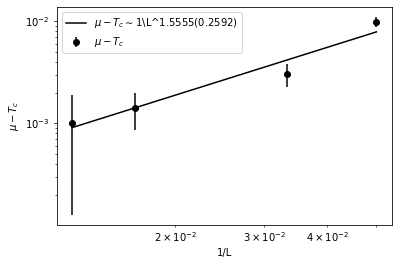

In [466]:
def line(x, a, b):
    return a*x + b 

def line_fit(y, x):
    popt, pcov = curve_fit(line, xdata=x, ydata=y, absolute_sigma=False, maxfev=100000)
    return popt, pcov

ls = np.array([1/L for L in [20, 30, 60, 80]])
#cs_ = np.array(popt_)[:, 1]  # mu 
cs_ = np.array(popt_)[:, 1] - T_c # mu - tc

pl_, pcov_ = line_fit(y=np.log(np.abs(cs_)), x=np.log(ls))

perr_line = np.sqrt(np.diag(pcov_))

#plt.scatter(ls, cs, color='red')
plt.errorbar(ls, cs_, yerr=perr_[:, 1], fmt="o", color='black', label='$\mu-T_c$')

plt.plot(ls, np.exp(line(np.log(ls), pl_[0], pl_[1])), color='black', label='$\mu-T_c\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_[0], 4), round(perr_line[0], 4)))

#plt.title(f'M = {M}')
plt.xlabel('1/L')
plt.ylabel('$\mu-T_c$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig(f'images/jd-{Jd}-mu.png')

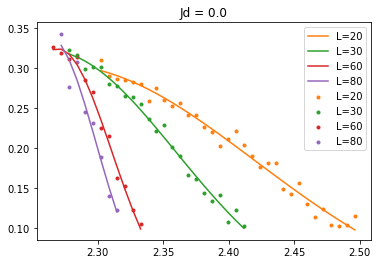

In [467]:
data = []

for j in range(len(Ls)):
    dt = stds_err(outs_[j])[T >= T[np.argmin(np.abs(stds_err(outs_[j]) - popt_[j, 1]))]] 
    data.append(dt[dt >= threshold[j]])
temp = [T[T >= T[np.argmin(np.abs(stds_err(outs_[j]) - popt_[j, 1]))]][:data[j].shape[0]] for j in range(len(Ls))]


p_ = [[np.max(stds_err(outs_[j])), T[np.argmax(stds_err(outs_[j]))], np.std(stds_err(outs_[j])) / 2] for j in range(len(Ls))]

#tmp = [gaussian_fit_with_p(y=errs(errs_[j]), x=T, p=p_[j]) for j in range(len(Ls))]
tmp = [gaussian_fit_with_p(y=data[j], x=temp[j], p=p_[j]) for j in range(len(Ls))]
#tmp = [gaussian_fit(y=data[j], x=temp[j]) for j in range(len(Ls))]

popt_r = np.array([tmp[j][0] for j in range(len(Ls))])
pcov_r = np.array([tmp[j][1] for j in range(len(Ls))])

plt.figure()

for j in range(len(Ls)):
    plt.plot(temp[j], gaussian(temp[j], popt_r[j][0], popt_r[j][1], popt_r[j][2]), label=f'L={Ls[j]}', c=f'C{j+1}')
    plt.scatter(temp[j], data[j], label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    
    #plt.scatter(T, stds_err(outs_[j][:, 0]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    #plt.scatter(T, errs(errs_[j]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')

#plt.axvline(x=T_c, color='black', linestyle='--')

#plt.axvline(x=popt_[2][1] - 3*popt_[2][2], color='blue', linestyle='-')
#plt.axvline(x=popt_[2][1] + 3*popt_[2][2], color='blue', linestyle='-')

plt.title(f'Jd = {Jd}')
plt.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()

In [468]:
perr_r = np.array([np.sqrt(np.diag(pcov_r[j, :])) for j in range(len(Ls))])

popt_r, perr_r
# for j in range(len(Ls)):
#     print(popt_[j, 2], perr_[j, 2])

(array([[0.11459159, 2.26951288, 0.15042931],
        [0.07869497, 2.26214752, 0.09753492],
        [0.03322746, 2.26973369, 0.04088534],
        [0.03017495, 2.26343585, 0.03556977]]),
 array([[0.01149541, 0.01588924, 0.01019264],
        [0.00641   , 0.00840842, 0.00557439],
        [0.00208017, 0.00269633, 0.00218499],
        [0.01181173, 0.01464674, 0.00961817]]))

In [469]:
sigmas = []
for i in range(popt_r[:, 2].shape[0]):
    sigmas.append(str(round(popt_r[i, 2], 4)) + '(' + str(round(perr_r[i, 2], 4)) + ')')
    
df['\sigma_r'] = sigmas
df

,$J_d$,L,\mu,T_c,\sigma,\sigma_r,\sigma_l
0,0.0,20,2.279(0.0011),2.269,0.1453(0.0015),0.1504(0.0102),NaN
1,0.0,30,2.2722(0.0008),2.269,0.0932(0.001),0.0975(0.0056),NaN
2,0.0,60,2.2706(0.0006),2.269,0.041(0.0007),0.0409(0.0022),NaN
3,0.0,80,2.2702(0.0009),2.269,0.0305(0.0011),0.0356(0.0096),NaN


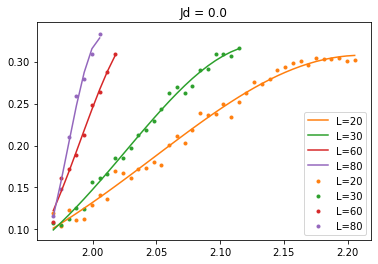

In [470]:
data = []

for j in range(len(Ls)):
    dt = stds_err(outs_[j])[T < T[np.argmin(np.abs(stds_err(outs_[j]) - popt_[j, 1]))]] 
    data.append(dt[dt >= threshold[j]])
temp = [T[T < T[np.argmin(np.abs(stds_err(outs_[j]) - popt_[j, 1]))]][:data[j].shape[0]] for j in range(len(Ls))]


p_ = [[np.max(data[j]), T[np.argmax(stds_err(outs_[j]))], np.std(data[j])] for j in range(len(Ls))]

tmp = [gaussian_fit_with_p(y=data[j], x=temp[j], p=p_[j]) for j in range(len(Ls))]
#tmp = [gaussian_fit(y=data[j], x=temp[j]) for j in range(len(Ls))]

popt_l = np.array([tmp[j][0] for j in range(len(Ls))])
pcov_l = np.array([tmp[j][1] for j in range(len(Ls))])

plt.figure()

for j in range(len(Ls)):
    plt.plot(temp[j], gaussian(temp[j], popt_l[j][0], popt_l[j][1], popt_l[j][2]), label=f'L={Ls[j]}', c=f'C{j+1}')
    plt.scatter(temp[j], data[j], label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    
    #plt.scatter(T, stds_err(outs_[j][:, 0]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')
    #plt.scatter(T, errs(errs_[j]), label=f'L={Ls[j]}', marker='.', c=f'C{j+1}')

#plt.axvline(x=T_c, color='black', linestyle='--')

#plt.axvline(x=popt_[2][1] - 3*popt_[2][2], color='blue', linestyle='-')
#plt.axvline(x=popt_[2][1] + 3*popt_[2][2], color='blue', linestyle='-')

plt.title(f'Jd = {Jd}')
plt.legend()
#plt.xlim(T_c-0.1, T_c+0.1)
plt.show()

In [471]:
perr_l = np.array([np.sqrt(np.diag(pcov_l[j, :])) for j in range(len(Ls))])

popt_l, perr_l
# for j in range(len(Ls)):
#     print(popt_[j, 2], perr_[j, 2])

(array([[0.1252938 , 2.21115633, 0.16250707],
        [0.08717439, 2.13504531, 0.10832327],
        [0.04267615, 2.04059642, 0.04986668],
        [0.02152596, 2.00698739, 0.02612877]]),
 array([[0.00645022, 0.00870748, 0.00645457],
        [0.00561607, 0.00738262, 0.00481147],
        [0.01346425, 0.01642246, 0.0092964 ],
        [0.00258839, 0.00329712, 0.00251254]]))

In [472]:
sigmas = []
for i in range(popt_r[:, 2].shape[0]):
    sigmas.append(str(round(popt_l[i, 2], 4)) + '(' + str(round(perr_l[i, 2], 4)) + ')')
    
df['\sigma_l'] = sigmas
df

,$J_d$,L,\mu,T_c,\sigma,\sigma_r,\sigma_l
0,0.0,20,2.279(0.0011),2.269,0.1453(0.0015),0.1504(0.0102),0.1625(0.0065)
1,0.0,30,2.2722(0.0008),2.269,0.0932(0.001),0.0975(0.0056),0.1083(0.0048)
2,0.0,60,2.2706(0.0006),2.269,0.041(0.0007),0.0409(0.0022),0.0499(0.0093)
3,0.0,80,2.2702(0.0009),2.269,0.0305(0.0011),0.0356(0.0096),0.0261(0.0025)


In [473]:
df_res = pd.concat([df_res,df])
df_res

,$J_d$,L,\mu,T_c,\sigma,\sigma_r,\sigma_l
0,-0.9,20,0.3461(0.0034),0.289,0.0319(0.0034),1.0006(1.0987),2.5333(378.2531)
1,-0.9,30,0.3516(0.0029),0.289,0.0346(0.0029),0.0138(0.0021),0.0408(0.0078)
2,-0.9,60,0.356(0.0016),0.289,0.0221(0.0016),0.1529(0.3739),0.3002(nan)
3,-0.9,80,0.342(0.0008),0.289,0.0165(0.0008),0.0246(0.0032),0.0352(0.0091)
0,-0.8,20,0.6909(0.0031),0.576,0.0743(0.0031),1.0221(6.4719),0.0868(0.0226)
1,-0.8,30,0.6807(0.0013),0.576,0.0569(0.0013),0.0717(0.0032),0.0334(0.001)
2,-0.8,60,0.6889(0.0003),0.576,0.031(0.0003),0.0384(0.0013),0.0253(0.0005)
3,-0.8,80,0.6814(0.0002),0.576,0.0235(0.0002),0.0299(0.0004),0.0196(0.0004)
0,-0.7,20,0.9499(0.0026),0.854,0.0971(0.0031),0.1385(0.0057),0.0442(0.0023)
1,-0.7,30,0.9477(0.0016),0.854,0.0607(0.0018),0.0897(0.0047),0.0394(0.0028)


In [474]:
print(df_res.to_latex(index=False)) 

\begin{tabular}{rllrlll}
\toprule
 \$J\_d\$ &  L &            \textbackslash mu &   T\_c &         \textbackslash sigma &       \textbackslash sigma\_r &         \textbackslash sigma\_l \\
\midrule
  -0.9 & 20 & 0.3461(0.0034) & 0.289 & 0.0319(0.0034) & 1.0006(1.0987) & 2.5333(378.2531) \\
  -0.9 & 30 & 0.3516(0.0029) & 0.289 & 0.0346(0.0029) & 0.0138(0.0021) &   0.0408(0.0078) \\
  -0.9 & 60 &  0.356(0.0016) & 0.289 & 0.0221(0.0016) & 0.1529(0.3739) &      0.3002(nan) \\
  -0.9 & 80 &  0.342(0.0008) & 0.289 & 0.0165(0.0008) & 0.0246(0.0032) &   0.0352(0.0091) \\
  -0.8 & 20 & 0.6909(0.0031) & 0.576 & 0.0743(0.0031) & 1.0221(6.4719) &   0.0868(0.0226) \\
  -0.8 & 30 & 0.6807(0.0013) & 0.576 & 0.0569(0.0013) & 0.0717(0.0032) &    0.0334(0.001) \\
  -0.8 & 60 & 0.6889(0.0003) & 0.576 &  0.031(0.0003) & 0.0384(0.0013) &   0.0253(0.0005) \\
  -0.8 & 80 & 0.6814(0.0002) & 0.576 & 0.0235(0.0002) & 0.0299(0.0004) &   0.0196(0.0004) \\
  -0.7 & 20 & 0.9499(0.0026) & 0.854 & 0.0971(0.0031) & 0.

In [475]:
cs_

array([0.0098319 , 0.00303866, 0.00140673, 0.00100295])

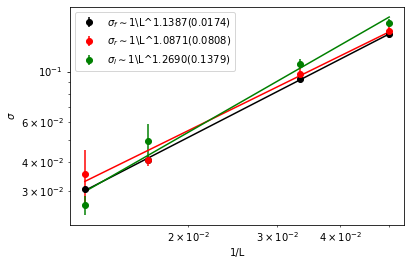

In [476]:
def line(x, a, b):
    return a*x + b 

def line_fit(y, x):
    popt, pcov = curve_fit(line, xdata=x, ydata=y, absolute_sigma=False, maxfev=100000)
    return popt, pcov

ls = np.array([1/L for L in [20, 30, 60, 80]])
cs_ = np.abs(np.array(popt_)[:, 2]) # sigma 
cs_r = np.abs(np.array(popt_r)[:, 2]) # sigma 
cs_l = np.abs(np.array(popt_l)[:, 2]) # sigma 

pl_, pcov_ = line_fit(y=np.log(np.abs(cs_)), x=np.log(ls))
pl_r, pcov_r = line_fit(y=np.log(np.abs(cs_r)), x=np.log(ls))
pl_l, pcov_l = line_fit(y=np.log(np.abs(cs_l)), x=np.log(ls))
#pl_00 = np.polyfit(np.log(ls), np.log(cs), 1)

perr_line = np.sqrt(np.diag(pcov_))
perr_r_line = np.sqrt(np.diag(pcov_r))
perr_l_line = np.sqrt(np.diag(pcov_l))

#plt.scatter(ls, cs, color='red')
plt.errorbar(ls, cs_, yerr=perr_[:, 2], fmt="o", color='black', label='$\sigma_f\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_[0], 4), round(perr_line[0], 4)))
plt.errorbar(ls, cs_r, yerr=perr_r[:, 2], fmt="o", color='red', label='$\sigma_r\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_r[0], 4), round(perr_r_line[0], 4)))
plt.errorbar(ls, cs_l, yerr=perr_l[:, 2], fmt="o", color='green', label='$\sigma_l\sim$1\L^{0:.4f}({1:.4f})'.format(round(pl_l[0], 4), round(perr_l_line[0], 4)))
#plt.plot(ls, np.exp(np.poly1d(pl_00)(np.log(ls))))

plt.plot(ls, np.exp(line(np.log(ls), pl_[0], pl_[1])), color='black')
plt.plot(ls, np.exp(line(np.log(ls), pl_r[0], pl_r[1])), color='red')
plt.plot(ls, np.exp(line(np.log(ls), pl_l[0], pl_l[1])), color='green')

#plt.title(f'M = {M}')
plt.xlabel('1/L')
plt.ylabel('$\sigma$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig(f'images/jd=-{Jd}-sigmas.png')

In [477]:
pl_, pcov_

(array([1.13874423, 1.48723954]),
 array([[0.00030182, 0.00112225],
        [0.00112225, 0.0042638 ]]))

In [478]:
perr_ = np.sqrt(np.diag(pcov_))
perr_

array([0.01737288, 0.06529776])

### $\delta = \frac{T^*-T_c}{T_c}$

In [ ]:
from scipy.optimize import curve_fit


def gaussian(x, amp, mu, sigma):
    return (amp/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x-mu)**2 / (2*sigma**2))

def gaussian_fit(x, y):
    popt, pcov = curve_fit(gaussian, xdata=x, ydata=y,
                              absolute_sigma=False, maxfev=1000000)
    return popt, pcov

def gaussian_fit_with_p(x, y, p):
    popt, pcov = curve_fit(gaussian, xdata=x, ydata=y,
                              absolute_sigma=False, p0=p, maxfev=1000000)
    return popt, pcov

df_res = pd.DataFrame(columns=['$J_d$', 'L', '\mu', 'T_c', '\sigma', '\sigma_r', '\sigma_l'])

for Jd in tqdm(jds):
    T_c = get_crit_T[Jd]
    T = np.linspace(T_c - 0.3, T_c + 0.3, num_temps)

    opt_epochs = np.load('opt_epochs.npy', allow_pickle='TRUE').item()
    epochs = opt_epochs[Jd]

    errs_ = []
    outs_ = []
    Ls = [20, 30, 60, 80]
    
    for i, L in enumerate(Ls):
        num_epochs = epochs[i]
        with open(f'data_errors/{Jd}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
            errs_.append(np.load(f)) 
        with open(f'data_outputs/{Jd}_{L}_{num_temps}_{num_epochs}_epochs.npy', 'rb') as f:
            outs_.append(np.squeeze(np.load(f)))


    p_ = [[np.max(stds_err(outs_[j])), T[np.argmax(stds_err(outs_[j]))], np.std(stds_err(outs_[j])) / 2] for j in range(len(Ls))]

    if Jd in [-0.9, -0.8]:
        threshold = [0.0, 0.0, 0.0, 0.0, 0.0]
    elif Jd in [-0.7, -0.6]:
        threshold = [0.05, 0.05, 0.05, 0.05, 0.05]
    else:
        threshold = [0.1, 0.1, 0.1, 0.1, 0.1]


    data = [stds_err(outs_[j])[stds_err(outs_[j]) > threshold[j]] for j in range(len(Ls))]
    temp = [T[stds_err(outs_[j]) > threshold[j]] for j in range(len(Ls))]

    tmp = [gaussian_fit_with_p(y=data[j], x=temp[j], p=p_[j]) for j in range(len(Ls))]
    
    popt_ = np.array([tmp[j][0] for j in range(len(Ls))])
    pcov_ = np.array([tmp[j][1] for j in range(len(Ls))])
    perr_ = np.array([np.sqrt(np.diag(pcov_[j, :])) for j in range(len(Ls))])

    df = pd.DataFrame(columns=['$J_d$', 'L', '\mu', 'T_c', '\sigma', '\sigma_r', '\sigma_l'])
    df['$J_d$'] = [Jd]*len(Ls)
    df['L'] = [20,30,60,80]

    mus = []
    for i in range(popt_[:, 1].shape[0]):
        mus.append(str(round(popt_[i, 1], 4)) + '(' + str(round(perr_[i, 1], 4)) + ')')

    df['\mu'] = mus 
    df['T_c'] = np.round([T_c]*len(Ls), 3)

    sigmas = []
    for i in range(popt_[:, 2].shape[0]):
        sigmas.append(str(round(popt_[i, 2], 4)) + '(' + str(round(perr_[i, 2], 4)) + ')')

    df['\sigma'] = sigmas

    data = []

    for j in range(len(Ls)):
        dt = stds_err(outs_[j])[T >= T[np.argmin(np.abs(stds_err(outs_[j]) - popt_[j, 1]))]] 
        data.append(dt[dt >= threshold[j]])
    temp = [T[T >= T[np.argmin(np.abs(stds_err(outs_[j]) - popt_[j, 1]))]][:data[j].shape[0]] for j in range(len(Ls))]

    p_ = [[np.max(stds_err(outs_[j])), T[np.argmax(stds_err(outs_[j]))], np.std(stds_err(outs_[j])) / 2] for j in range(len(Ls))]
    tmp = [gaussian_fit_with_p(y=data[j], x=temp[j], p=p_[j]) for j in range(len(Ls))]
    
    popt_r = np.array([tmp[j][0] for j in range(len(Ls))])
    pcov_r = np.array([tmp[j][1] for j in range(len(Ls))])
    perr_r = np.array([np.sqrt(np.diag(pcov_r[j, :])) for j in range(len(Ls))])

    sigmas = []
    for i in range(popt_r[:, 2].shape[0]):
        sigmas.append(str(round(popt_r[i, 2], 4)) + '(' + str(round(perr_r[i, 2], 4)) + ')')

    df['\sigma_r'] = sigmas

    data = []

    for j in range(len(Ls)):
        dt = stds_err(outs_[j])[T < T[np.argmin(np.abs(stds_err(outs_[j]) - popt_[j, 1]))]] 
        data.append(dt[dt >= threshold[j]])
    temp = [T[T < T[np.argmin(np.abs(stds_err(outs_[j]) - popt_[j, 1]))]][:data[j].shape[0]] for j in range(len(Ls))]


    p_ = [[np.max(data[j]), T[np.argmax(stds_err(outs_[j]))], np.std(data[j])] for j in range(len(Ls))]

    tmp = [gaussian_fit_with_p(y=data[j], x=temp[j], p=p_[j]) for j in range(len(Ls))]
    #tmp = [gaussian_fit(y=data[j], x=temp[j]) for j in range(len(Ls))]

    popt_l = np.array([tmp[j][0] for j in range(len(Ls))])
    pcov_l = np.array([tmp[j][1] for j in range(len(Ls))])
    perr_l = np.array([np.sqrt(np.diag(pcov_l[j, :])) for j in range(len(Ls))])

    sigmas = []
    for i in range(popt_r[:, 2].shape[0]):
        sigmas.append(str(round(popt_l[i, 2], 4)) + '(' + str(round(perr_l[i, 2], 4)) + ')')

    df['\sigma_l'] = sigmas

    df_res = pd.concat([df_res,df])